In [68]:
# Dataset configuration (resize images, load images, split dataset into train, validation, test)

import os
import cv2
import numpy as np

img_size = (150, 150)

train_dir = '../../dataset/train'
validation_dir = '../../dataset/val'
test_dir = '../../dataset/test'

def getCode(label):
    if label == 'NORMAL':
        return 0
    return 1

def resize_images_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            images.append(img)            
            labels.append(getCode(label))
            
    if (directory == train_dir):
        images = images[:3500]
        labels = labels[:3500]

    return np.array(images), np.array(labels)


X_train, y_train = resize_images_from_directory(train_dir)
X_validation, y_validation = resize_images_from_directory(validation_dir)
X_test, y_test = resize_images_from_directory(test_dir)

X_train = X_train.reshape([-1, np.prod((150, 150, 3))])
X_validation = X_validation.reshape([-1, np.prod((150, 150, 3))])
X_test = X_test.reshape([-1, np.prod((150, 150, 3))])

In [69]:
# Use pipeline to scale the data and train the model

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

model = KNeighborsClassifier()

model.fit(X_train, y_train)
print("Train score", model.score(X_train, y_train))
print("Test score", model.score(X_test, y_test))

print("-----------------------------------")

model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=10))
smote = SMOTE(random_state=11)
X_train, y_train = smote.fit_resample(X_train, y_train)

params = {
    # 'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5],
    # 'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    # 'kneighborsclassifier__leaf_size': [20, 30, 40],
}

grid = GridSearchCV(model, params, cv=5)
grid.fit(X_train, y_train)
print("Train score", grid.score(X_train, y_train))
print("Test score", grid.score(X_test, y_test))

Train score 0.9522622699386503
Test score 0.7371794871794872
-----------------------------------
Train score 0.7691612903225806
Test score 0.7435897435897436


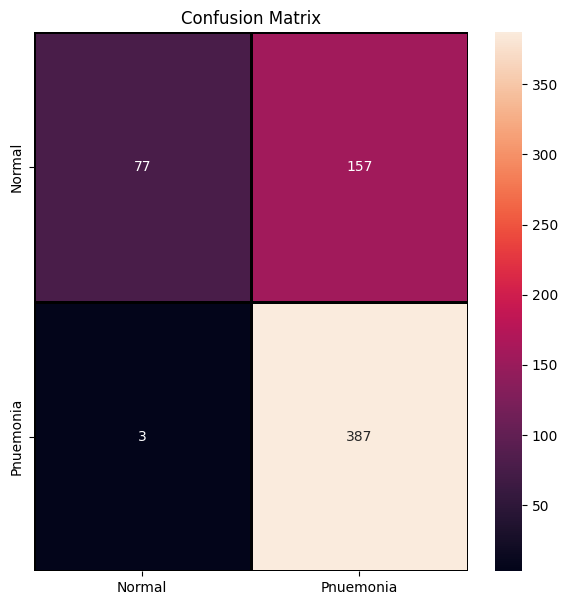

In [70]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_cm(predictions, y_test, title):
  labels = ['Normal', 'Pnuemonia']
  cm = confusion_matrix(y_test,predictions)
  cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
  plt.figure(figsize = (7,7))
  plt.title(title)
  sns.heatmap(cm, linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)
  plt.show()

plot_cm(grid.predict(X_test), y_test, 'Confusion Matrix')

Success Rate: 0.7660256410256411
Success Rate for Pneumonia: 0.9871794871794872
Success Rate for Normal: 0.3974358974358974


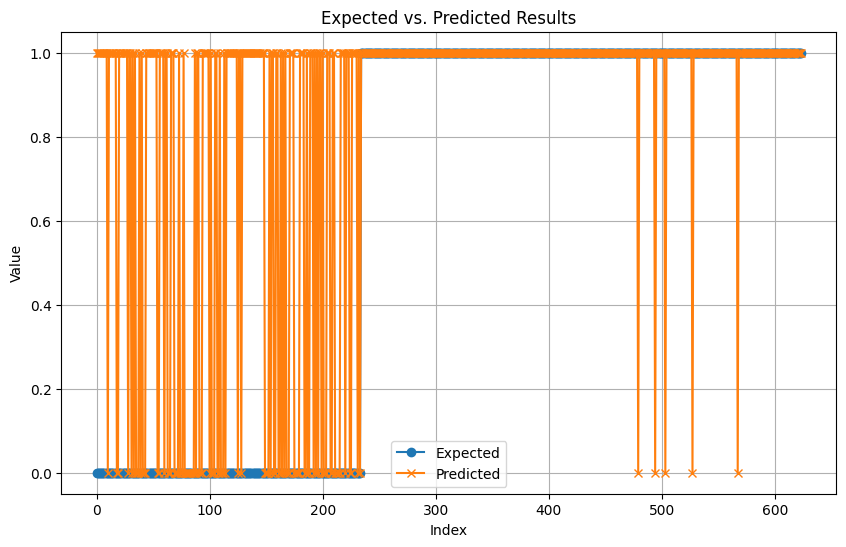

In [49]:
# Evaluate the model
predictions = grid.predict(X_test)
indices = np.arange(len(y_test))

def success_rate() :
    num_correct = sum(y_test == predictions)
    total_predictions = len(y_test)
    return num_correct / total_predictions

def success_rate_per_class(class_code):
    expected = y_test[y_test == class_code]
    predicted = predictions[y_test == class_code]
    num_correct = sum(expected == predicted)
    total_predictions = len(expected)
    return num_correct / total_predictions

print("Success Rate:", success_rate())
print("Success Rate for Pneumonia:", success_rate_per_class(1))
print("Success Rate for Normal:", success_rate_per_class(0))

plt.figure(figsize=(10, 6))
plt.plot(indices, y_test, label='Expected', marker='o')
plt.plot(indices, predictions, label='Predicted', marker='x')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Expected vs. Predicted Results')
plt.legend()
plt.grid(True)
plt.show()